In [47]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from random import randint as rand
from skimage import io
from math import ceil, floor
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'



In [48]:
##Objetos y funciones globales necesarios
imagenes = {}

def plot_img(img, title):
    name, image = img
    fig = plt.gcf()
    fig.set_size_inches(10,5)
    plt.imsave('resultados/{}_{}.jpg'.format(title,name),image)
    plt.title(name+ title)
    plt.imshow(image)
    plt.show()
    

    
    
def gaussian_noise(img):
    img2 = img.copy() * 255
    noise = np.random.normal(0, 40, img2.shape) 
    img_noised = img2 + noise
    img_noised = np.clip(img_noised, 0, 255)
    return (np.rint(img_noised)/255, noise)

def salt_pepper_noise(img):
    img2 = img.copy() *255
    y_space, x_space = img.shape
    pepper = 0.125
    salt = 1 - pepper
    for y in range(y_space):
        for x in range(x_space):
            rdn = np.random.random()
            if rdn < pepper:
                img2[y][x] = 0
            elif rdn > salt:
                img2[y][x] = 1
    return img2/255

In [49]:
## Funcioenes
def convolution(section, filter, factor):
    convol = np.multiply(section,filter)
    return convol.sum() * (1/factor)

def convolutionG(section,filter,factor):
    convol = np.multiply(section,filter)
    return np.power(np.prod(convol),1/factor) 

def convolutionAdap(section,filter):
    convol = np.multiply(section,filter)
    mean =  np.mean(convol)
    local_variance = np.mean(np.power(convol,2)) - np.power(mean,2)
    return (local_variance,mean)
    
def aply_adap_filter(img,filter):
    fileter_size = filter.shape[0]
    padding = fileter_size // 2
    local_v = 0
    mean = 0
    noise_variance = 48**2
    resultado = img.copy() *255
    img3 = np.pad(resultado, pad_width=padding, mode='constant', constant_values=0)
    y_space, x_space = img3.shape
    for y in range(padding,y_space-padding):
        for x in range(padding,x_space-padding):
            section = img3[y-padding:y+fileter_size-padding, x-padding:x+fileter_size-padding]
            local_v, mean = convolutionAdap(section,filter)  
            if local_v < noise_variance:
                local_v = noise_variance
            resultado[y-padding][x-padding] = img[y-padding][x-padding] - (noise_variance/local_v) * (img[y-padding][x-padding] - mean)
    return np.rint(resultado)/255

    
    

def apply_filter(img,filter,geom = 1):
    fileter_size = filter.shape[0]
    factor = fileter_size*fileter_size
    padding = fileter_size // 2
    img2 = img.copy() * 255
    img3 = np.pad(img2, pad_width=padding, mode='constant', constant_values=0)
    y_space, x_space = img3.shape
    for y in range(padding,y_space-padding):
        for x in range(padding,x_space-padding):
            section = img3[y-padding:y+fileter_size-padding, x-padding:x+fileter_size-padding]
            if geom == 2:
                img2[y-padding][x-padding] = convolutionG(section,filter,factor)
            else:
                img2[y-padding][x-padding] = convolution(section,filter,factor)
    return np.rint(img2)/255

def make_filter(shape):
    return np.ones(shape)

def make_filter_p(shape):
    filter =  np.ones(shape)
    y_space, x_space = shape
    y_aux, x_aux = y_space-1, x_space-1
    y_2 = y_aux
    aux = y_space//2 
    for y in range(y_space):
        x_aux = x_space-1
        x_2 = x_aux
        for x in range(x_space):
            filter[y][x] = 2**(y_aux - np.clip(y_2,0,y_space)) * 2**(x_aux - np.clip(x_2,0,x_space)) 
            x_aux -= 1
            x_2 -= 2
        y_aux -= 1
        y_2 -=2
    return filter  

In [50]:
def mediana(section):
    section = np.sort(section.flatten())
    if (len(section)%2 == 1):
        return section[len(section)//2]
    else:
        return ((section[len(section)//2] + section[(len(section)//2) -1])/2)
def mediana_adap(section):
    section2 = np.sort(section.flatten())
    pixel = section.flatten()[len(section)//2]
    median = 0
    if (len(section2)%2 == 1):
        median = section2[len(section)//2]
    else:
        median ((section2[len(section)//2] + section2[(len(section2)//2)-1])/2)
    min =  section2.min()
    max = section2.max()
    if (median > min and median < max):
        if (pixel> min and pixel < max):
            return pixel
        else:
            return median
    else:
        return False
    

def filtro_mediana_adap(img,size):
    padding_over = size // 2
    pad = 3
    padding = 3 // 2
    median = 0
    img2 = img.copy() * 255
    img7 = np.pad(img2, pad_width=padding_over, mode='constant', constant_values=0)
    img5 = np.pad(img2, pad_width=5//2, mode='constant', constant_values=0)
    img3 = np.pad(img2, pad_width=3//2, mode='constant', constant_values=0)
    
    y_space, x_space = img3.shape
    for y in range(padding_over,y_space-padding_over):
        for x in range(padding_over,x_space-padding_over):
            if pad == 3:
                section = img3[y-padding:y+pad-padding, x-padding:x+pad-padding]
            elif pad == 5:
                section = img5[y-padding:y+pad-padding, x-padding:x+pad-padding]
            else:
                section = img7[y-padding:y+pad-padding, x-padding:x+pad-padding]          
            median= mediana(section)
            if median == False and padding < padding_over:
                padding = (pad + 2)//2
                pad +=2
                x -= 1 
                continue
            elif padding>= padding_over: 
                padding = 3//2
                pad = 3
                continue
            img2[y-padding][x-padding] = median
            padding = 3//2
            pad = 3
            
    return np.rint(img2)/255
    
    
def filtro_mediana(img,size):
    padding = size // 2
    img2 = img.copy() * 255
    img3 = np.pad(img2, pad_width=padding, mode='constant', constant_values=0)
    y_space, x_space = img3.shape
    for y in range(padding,y_space-padding):
        for x in range(padding,x_space-padding):
            section = img3[y-padding:y+size-padding, x-padding:x+size-padding]
            img2[y-padding][x-padding] = mediana(section)
    return np.rint(img2)/255

In [51]:
### Wiener Functions

def wiener(image,noise,case):
    r = image - noise
    fourier_I = np.fft.fft2(image)
    fourier_N = np.fft.fft2(noise)
    fourier_R = np.fft.fft2(r)
    magnitud_I =  abs(fourier_I)
    magnitud_N =  abs(fourier_N)
    magnitud_R =  abs(fourier_R)
    G = None
    if case == 1:
        W = magnitud_I / (magnitud_I+ magnitud_R)
        G = W * fourier_N
    elif case == 2:
        H = fourier_N / fourier_I
        W = 1 / H
        G = W * fourier_N;
    elif case == 3:
        W = magnitud_I / (magnitud_I+magnitud_N)
        H = fourier_N / fourier_I
        W2 = 1/H
        W3 = W * W2
        G = W3 * fourier_N
    elif case == 4:
        H = fourier_N / fourier_I
        H_star = np.conjugate(H)
        W = (magnitud_I * H_star) / ((H * magnitud_I) * H_star + magnitud_R)
        G = W * fourier_N

    return np.real(np.fft.ifft2(G))



In [52]:
rm=io.imread('Imagenes/circuit2.tif')/255
imagenes['Circuito'] =  rm
rm=io.imread('Imagenes/lenag.bmp')/255
imagenes['Lena'] = rm


In [53]:
## FILTROS 
filtros = {}
filtros_p = {}
formas_filtros = [3,5,7,9]

for shape in formas_filtros:
    filtros[shape] = make_filter((shape,shape))
    filtros_p[shape] = make_filter_p((shape,shape))

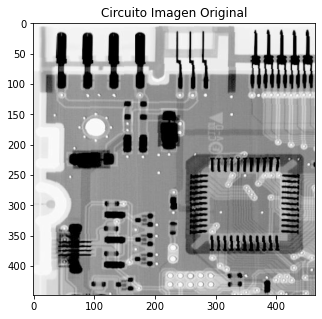

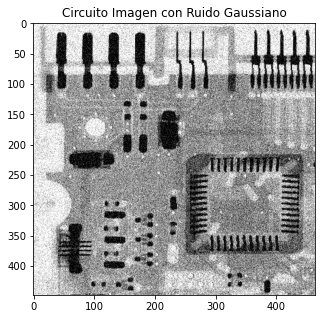

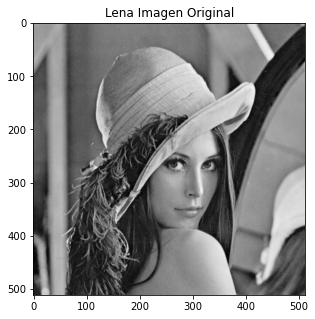

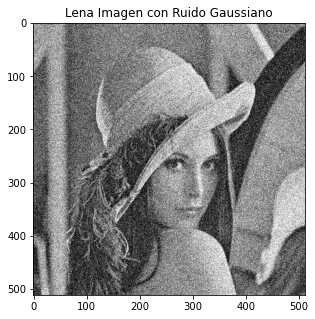

In [54]:
## IMAGENES CON RUIDO GAUSSIANO
noise = {}
imagenes_ruido_g = {}
for imagen in imagenes:
    imagenRuido,n = gaussian_noise(imagenes[imagen])
    noise[imagen] = n
    imagenes_ruido_g[imagen] = imagenRuido
    plot_img((imagen,imagenes[imagen]), ' Imagen Original')
    plot_img((imagen,imagenes_ruido_g[imagen]),' Imagen con Ruido Gaussiano')
    

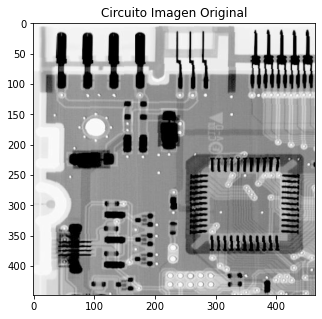

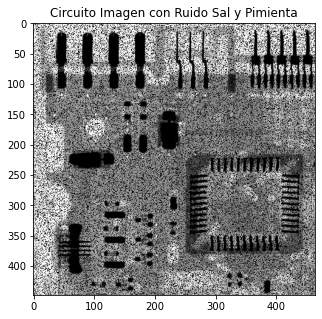

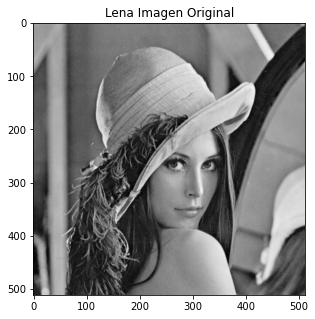

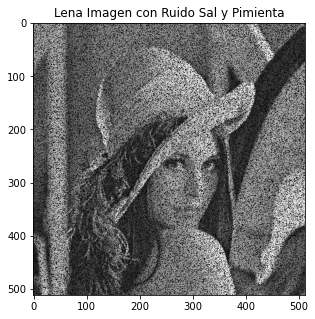

In [55]:
## IMAGENES CON RUIDO SAL Y PIMIENTA
imagenes_ruido_SP = {}
for imagen in imagenes:
    imagenes_ruido_SP[imagen] = salt_pepper_noise(imagenes[imagen])
    plot_img((imagen,imagenes[imagen]), ' Imagen Original')
    plot_img((imagen,imagenes_ruido_SP[imagen]),' Imagen con Ruido Sal y Pimienta')

In [56]:
### Ej1
imagen_circuito_meanA = apply_filter(imagenes_ruido_g['Circuito'],filtros[3])
imagen_circuito_meanG = apply_filter(imagenes_ruido_g['Circuito'],filtros[3],2)


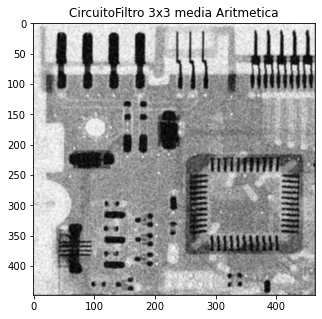

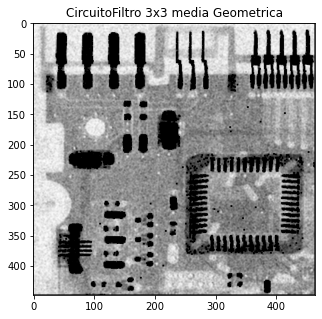

In [57]:
plot_img(('Circuito',imagen_circuito_meanA),'Filtro 3x3 media Aritmetica')
plot_img(('Circuito',imagen_circuito_meanG),'Filtro 3x3 media Geometrica')


In [58]:
### Ej2
imagen_circuito_meanA = apply_filter(imagenes_ruido_g['Circuito'],filtros[7])
imagen_circuito_meanG = apply_filter(imagenes_ruido_g['Circuito'],filtros[7],2)
imagen_circuito_adapt = aply_adap_filter(imagenes_ruido_g['Circuito'],filtros[7])


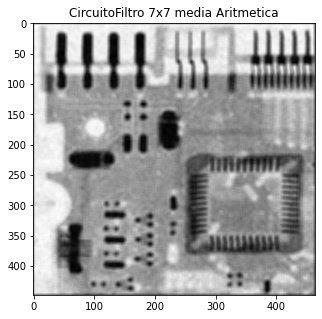

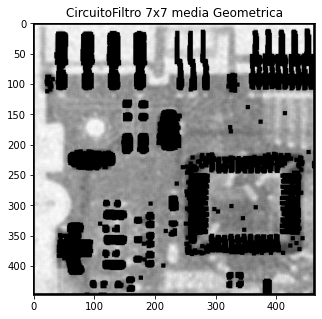

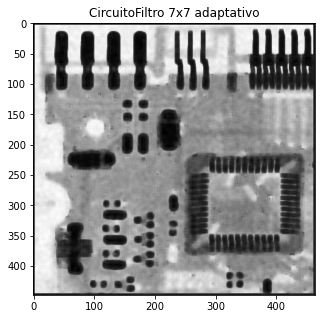

In [59]:
plot_img(('Circuito',imagen_circuito_meanA),'Filtro 7x7 media Aritmetica')
plot_img(('Circuito',imagen_circuito_meanG),'Filtro 7x7 media Geometrica')
plot_img(('Circuito',imagen_circuito_adapt),'Filtro 7x7 adaptativo')



In [72]:
### Ejercicio 3
imagen_circuito_medAd = filtro_mediana_adap(imagenes_ruido_SP['Circuito'],11)
imagen_circuito_med = filtro_mediana(imagenes_ruido_SP['Circuito'],7)

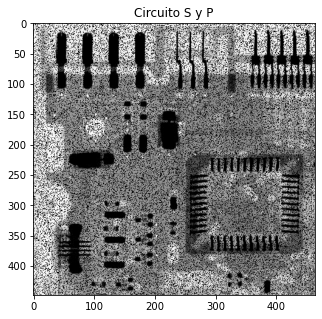

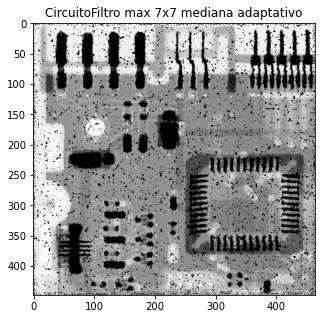

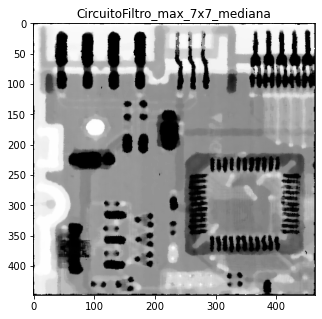

In [73]:
plot_img(('Circuito',imagenes_ruido_SP['Circuito']),' S y P')

plot_img(('Circuito',imagen_circuito_medAd),'Filtro max 7x7 mediana adaptativo')

plot_img(('Circuito',imagen_circuito_med),'Filtro_max_7x7_mediana')




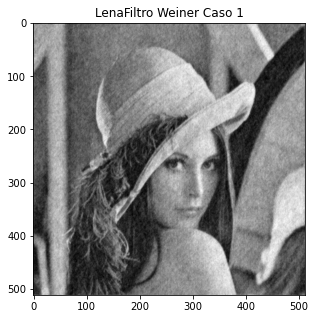

In [62]:
## Ejercicio 4
lena_ruido_G = imagenes_ruido_g['Lena']
img_lena = imagenes['Lena']
imagen_wiener1 = wiener(img_lena,lena_ruido_G,1)
plot_img(('Lena',imagen_wiener1),'Filtro Weiner Caso 1')



In [63]:
## Ejercicio 5
imagen_lena = imagenes['Lena']
lena_nitida = apply_filter(imagen_lena,filtros[9])



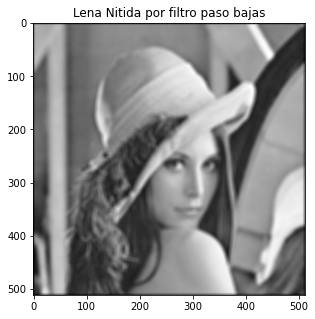

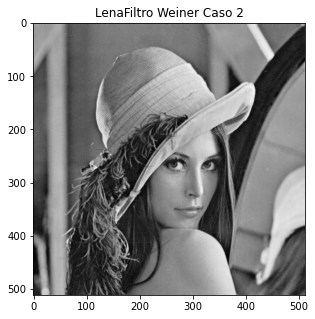

In [64]:
plot_img(('Lena',lena_nitida),' Nitida por filtro paso bajas')
imagen_wiener1 = wiener(img_lena,lena_nitida,2)
plot_img(('Lena',imagen_wiener1),'Filtro Weiner Caso 2')


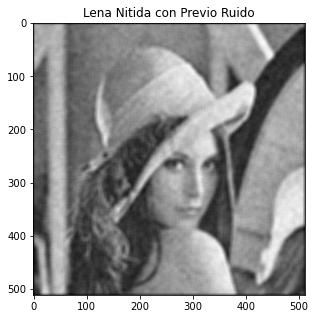

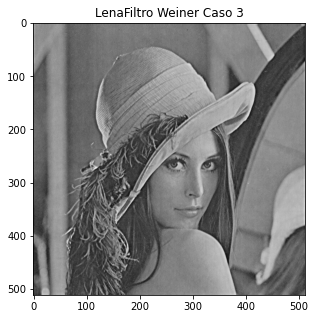

In [65]:
## Ejercicio 6
lena_ruido_nitida = apply_filter(lena_ruido_G,filtros[9])
plot_img(('Lena',lena_ruido_nitida),' Nitida con Previo Ruido')
imagen_wiener1 = wiener(img_lena,lena_ruido_nitida,3)
plot_img(('Lena',imagen_wiener1),'Filtro Weiner Caso 3')


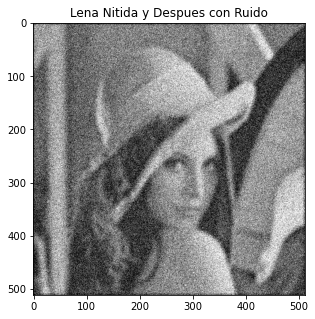

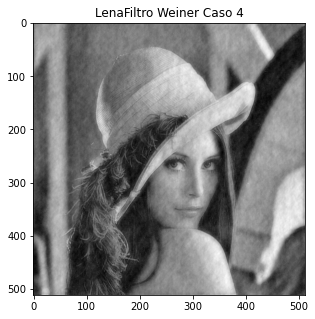

In [66]:
## Ejercico 7
lena_nitida_ruido, ruido_l = gaussian_noise(lena_nitida)
plot_img(('Lena',lena_nitida_ruido),' Nitida y Despues con Ruido')
imagen_wiener1 = wiener(img_lena,lena_nitida_ruido,4)
plot_img(('Lena',imagen_wiener1),'Filtro Weiner Caso 4')


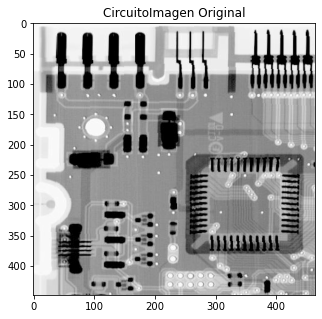

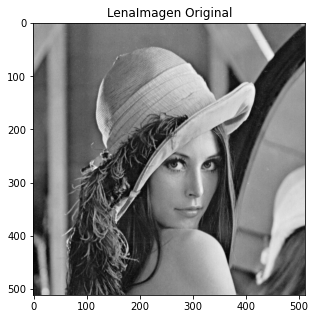

In [67]:
for img in imagenes:
    plot_img((img,imagenes[img]),'Imagen Original')